In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as io
import scipy.optimize as opt
from scipy import interpolate
from scipy.interpolate import UnivariateSpline


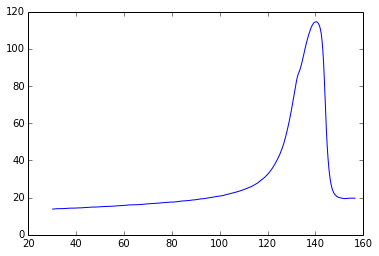

In [3]:
# load specific heat capacity (c_p) of the phase change material (pcm)

c_p_pcm_file = io.loadmat('code/c_p_pcm.mat')

T_grid = c_p_pcm_file['T_grid']
T_30 = np.where(T_grid > 30.)[0].min()

# last 8 entries are nan in c_p_pcm and temp > 30 C
c_p_pcm = c_p_pcm_file['c_p_pcm'][T_30:-8][:,0]
T_grid = c_p_pcm_file['T_grid'][T_30:-8][:,0]

plt.plot(T_grid, c_p_pcm)



Anm.: Kleine Unregelmaessigkeit im Peak, kann nicht mit geschlossener Form gefitted werden.

11
13


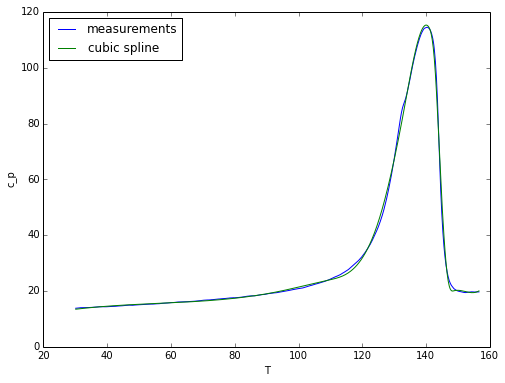

In [4]:



# B-spline interpolation
#tck = interpolate.splrep(T_grid, c_p_pcm, s=100.)
#c_p_cpm_spline = interpolate.splev(T_grid, tck)

# Cubic Spline interpolation
cubic_spline = interpolate.UnivariateSpline(T_grid, c_p_pcm, k=3)


print len(cubic_spline.get_knots())
print len(cubic_spline.get_coeffs())



fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(T_grid, c_p_pcm, 'blue', label='measurements')
#ax.plot(T_grid, c_p_cpm_fit, 'red', label='fit')

ax.plot(T_grid, cubic_spline(T_grid), 'green', label='cubic spline')
#ax.plot(T_grid, c_p_cpm_spline, 'green', label='B-spline')


#ax.plot(T_grid, popt[4]*T_grid + popt[5], 'green', label='sensible part')


ax.legend(loc=2)
ax.set_xlabel('T')
ax.set_ylabel('c_p')




/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


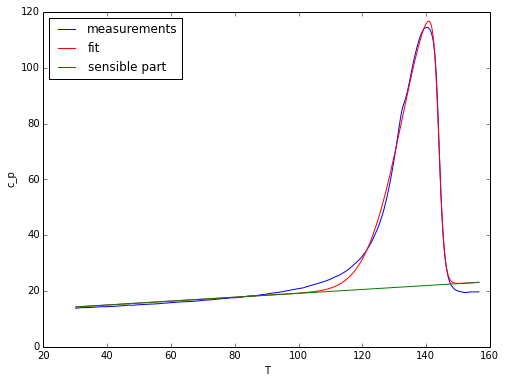

In [5]:
# fit c_p_pcm onto educated guessed function

def func1(x, *args):
    return ((np.arctan(-args[3]*(x-args[0]))+np.pi/2.)*
                    (args[1]*np.exp(-args[2]*(x-args[0])**2)) + args[4]*x + args[5])

def func2(x, *args):
    return ((1./(np.exp(args[3]*(x-args[0]))+1))*
                    (args[1]*np.exp(-args[2]*(x-args[0])**2)) + args[4]*x + args[5])




'''
x = np.linspace(30, 160., 100)
y = f(x, a=140., b=20., c=0.01, d=10, e=0.05, f=15.)
plt.plot(x, y)
'''

# fit
start_params = np.array([140., 100., 0.01, 0.7, 0.01, 15., 0.01])

[popt, pcov] = opt.curve_fit(func2, T_grid, c_p_pcm, start_params)
c_p_cpm_fit = func2(T_grid, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6])

## test start parameters s.t. fit converges
#c_p_cpm_fit = func1(T_grid, start_params[0], start_params[1], start_params[2], 
#                     start_params[3], start_params[4], start_params[5])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(T_grid, c_p_pcm, 'blue', label='measurements')
ax.plot(T_grid, c_p_cpm_fit, 'red', label='fit')
ax.plot(T_grid, popt[4]*T_grid + popt[5], 'green', label='sensible part')


ax.legend(loc=2)
ax.set_xlabel('T')
ax.set_ylabel('c_p')

Unklar wie man ohne viel mehr Parameter den Fit besser hinbekommen soll. Problem ist u.U. auch das hier die log. Wachstumsfunktion als Schaltfunktion genutzt wird und wenn diese zu steil wird es Probleme beim Loesen der DGL gibt.

Alternative waere eine Abschnittsweise Spline-Interpolation, allerdings wuerde dann die RHS der DGL nur Abschnittsweise gelten. Keine Ahnung wie damit umzugehen ist.

$\rightarrow$ Kann das SolvIND? Man muesste wahrscheinlich nen Cubic Spline oder aehnliches nehmen damit c_p(T) stetig differenzierbar ist weil in der RHS der term d(c_p)/dT ist


Anm.: Anzahl Koeff/Parameter ca. gleich bei Cubic Spline und lin. Interpol.